# Evaluating Scenario Outcomes With A/B Testing

## Introduction
A/B testing is a very common framework for comparing the outcomes of two scenarios. These could be two brand new scenarios or a new idea that you want to test against your current strategy. A/B testing will not outright tell you which scenario is better but it will tell you whether there is a statistical difference between the two. You can then consult other performance metrics to judge their effectiveness. 

This project will investigate two sets of data with different inputs and goals. The first is data from a mobile game called Cookie Cats that looks at retention rate and the second is data from an auction platform that looks at the participation rate of a questionnaire.

## Case Study 1: Cookie Cats - Mobile Game

Cookie Cats is a classic mobile puzzle game where you must connect three matching icons to get points and progress through the game's puzzles. As puzzles are completed users will level up their accounts and encounter more difficult puzzles. At certain levels there are content gates that require the user to wait a certain amount of time or make an in-game purchase to continue solving puzzles and level up further. 

The two scenarios we are analyzing for this case study are: the first content gate being at level 30 or at level 40. The three metrics we will be comparing between the two gate points are: the total number of rounds that the user played and whether they have returned to the game one or seven days after the original installation.

#### Data and Exploratory Analysis

In [1]:
#Import important packages
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

Once the data was loaded from .csv format it was inspected to determine if cleaning up needs to be done prior to the analysis. There are 90189 unique users and 5 categories of data for each user. The categories (columns) that are included are:
* userid: The unique user ID number
* version: Which level the content gate was placed at  
    * gate_30: The users who were content gated at level 30
    * gate_40: The users who were content gated at level 40
* sum_gamerounds: The total number of rounds the user has played.
* retention_1: Whether or not the user returned to the game 1 day after installation. 
* retention_7: Whether or not the user returned to the game 7 days after installation. 

In [2]:
# Load data from the .csv into a pandas data frame.
ccats = pd.read_csv('cookie_cats.csv')
ccats

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


The data was checked for null or missing values to ensure that no errors would occur later on and to check for completeness of the source data. 

In [3]:
#Check data set for missing or null values
ccats.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

The range of the game rounds was then checked to ensure that it was consistent and that there were no outliers. There was in fact one record with 50,000 game rounds recorded that was a clear outlier. It was removed so that it would not skew the rest of the data. Once that was done the range was much more consistent and very visually similar between both level gates.

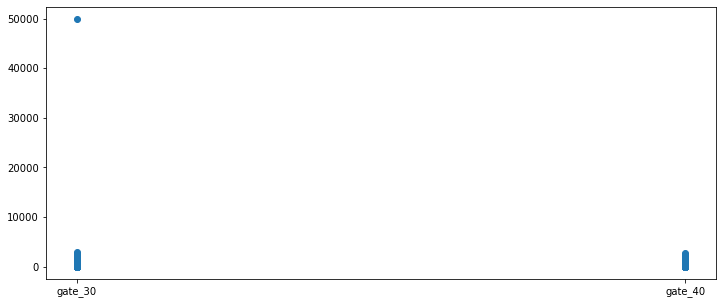

In [4]:
# Plot the sum_gameround distribution ofr each version
plt.figure(figsize = (12,5))
plt.scatter(x = ccats['version'], y = ccats['sum_gamerounds'])

In [5]:
# Remove all records with more than 10,000 total game rounds
ccats = ccats[ccats.sum_gamerounds < 10000]

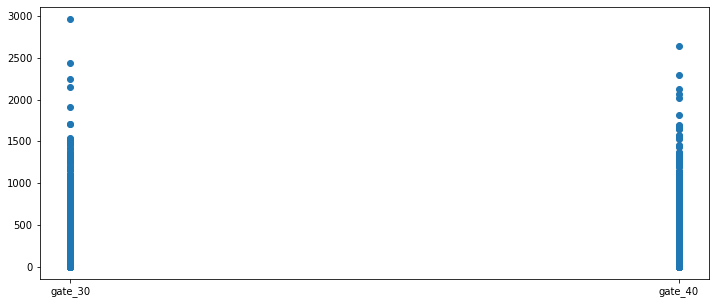

In [6]:
# Plot the sum_gameround distribution ofr each version
plt.figure(figsize = (12,5))
plt.scatter(x = ccats['version'], y = ccats['sum_gamerounds'])

The distribution of the number of game rounds played was also plotted to get a more detailed look at how this metric differed from on scenario to the next. A log y-axis was used to show this distribution more clearly. There was very little divergence between the two gates until you reached the upper limits of the games rounds played. This makes sense as it is less likely for users to reach those totals and therefore more divergence is expected because those events occur less often. 

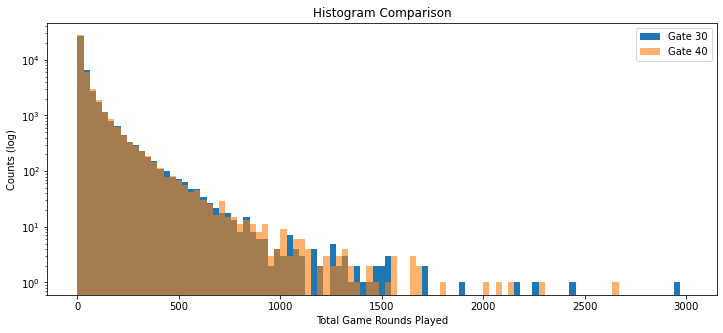

In [7]:
plt.figure(figsize = (12,5))
numBins = np.linspace(1, 3000, 100)
plt.hist(ccats['sum_gamerounds'].where(ccats['version'] == 'gate_30'), numBins, label = 'Gate 30')
plt.hist(ccats['sum_gamerounds'].where(ccats['version'] == 'gate_40'), numBins, label = 'Gate 40', alpha = 0.6)
plt.title('Histogram Comparison')
plt.ylabel('Counts (log)')
plt.xlabel('Total Game Rounds Played')
plt.yscale('log')
plt.legend()
plt.show()

A visual inspection of the retention columns was then conducted for two purposes. The first was to ensure that there was not a class imbalance between the two version types at all retention levels. The second was to see if there were any obvious differences between the 4 classes of users that could be used to double check the numeric analysis that will follow later in this project. 

In [8]:
# Creating variables for number of users in each of the 4 categories

# Number of users in version: gate_30 who returned after 1 day
thirtyOneT = len(ccats.loc[(ccats['version'] == 'gate_30') & (ccats['retention_1'] == True)])
# Number of users in version: gate_40 who returned after 1 day
fortyOneT = len(ccats.loc[(ccats['version'] == 'gate_40') & (ccats['retention_1'] == True)])
# Number of users in version: gate_30 who did not return after 1 day
thirtyOneF = len(ccats.loc[(ccats['version'] == 'gate_30') & (ccats['retention_1'] == False)])
# Number of users in version: gate_40 who did not return after 1 day
fortyOneF = len(ccats.loc[(ccats['version'] == 'gate_40') & (ccats['retention_1'] == False)])

# Number of users in version: gate_30 who returned after 7 days
thirtySevenT = len(ccats.loc[(ccats['version'] == 'gate_30') & (ccats['retention_7'] == True)])
# Number of users in version: gate_40 who returned after 7 days
fortySevenT = len(ccats.loc[(ccats['version'] == 'gate_40') & (ccats['retention_7'] == True)])
# Number of users in version: gate_30 who did not return after 7 days
thirtySevenF = len(ccats.loc[(ccats['version'] == 'gate_30') & (ccats['retention_7'] == False)])
# Number of users in version: gate_40 who did not return after 7 days
fortySevenF = len(ccats.loc[(ccats['version'] == 'gate_40') & (ccats['retention_7'] == False)])

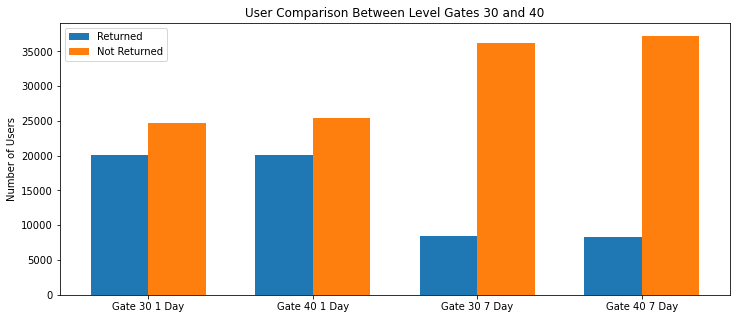

In [9]:
# Setting up the format variables for the bar graph
# Label names
labels = ['Gate 30 1 Day', 'Gate 40 1 Day', 'Gate 30 7 Day', 'Gate 40 7 Day']
# Array of returned user totals
trueGates = [thirtyOneT, fortyOneT, thirtySevenT, fortySevenT]
# Array of not returned iser totals
falseGates = [thirtyOneF, fortyOneF, thirtySevenF, fortySevenF]
# Bar width
width = 0.35
# Number of labels
labelLen = np.arange(len(labels))

# Creating the side-by-side bar graph
fig, ax = plt.subplots(figsize = (12,5))
gate1 = ax.bar(labelLen - width/2, trueGates, width, label = 'Returned')
gate2 = ax.bar(labelLen + width/2, falseGates, width, label = 'Not Returned')

# Graph elements
ax.set_ylabel('Number of Users')
ax.set_title('User Comparison Between Level Gates 30 and 40')
ax.set_xticks(labelLen)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

It is evident from this plot that the classes are evenly divided and that they both follow very similar trends when it comes to user retention and drop off between the one and seven day intervals. From this point we can't make any confident assumptions regarding which content level gate resulted in more retention or more game rounds played. This is where A/B tests truly shine. They can take very marginal differences between the outcomes of two scenarios and determine whether there is a statistically significant difference or not. 

#### Preliminary Comparisons

From the EDA and visual inspection of the plots we can tell that the two scenarios are very similar with consistent distributions and patterns. The three metrics that will be compared to evaluate whether these scenarios are different are:  
* Mean game rounds played (sum_gamerounds)
* One day retention rate (retention_1)
* Seven day retention rate (retention_7) 

In [10]:
# Mean game rounds played for each gate
meanThirty = ccats.loc[ccats['version'] == 'gate_30', 'sum_gamerounds'].mean()
meanForty = ccats.loc[ccats['version'] == 'gate_40', 'sum_gamerounds'].mean()

# Retention rates for (gate30 ret 1), (gate40 ret 1), (gate30 ret 7), (gate40 ret 7)
totalThirty = len(ccats.loc[(ccats['version'] == 'gate_30')])
totalForty = len(ccats.loc[(ccats['version'] == 'gate_40')])

rateThirtyOne = round((thirtyOneT/totalThirty)*100,2)
rateThirtySeven = round((thirtySevenT/totalThirty)*100,2)

rateFortyOne = round((fortyOneT/totalForty)*100,2)
rateFortySeven = round((fortySevenT/totalForty)*100,2)

print(f"The mean game rounds for the level 30 gate vs the level 40 gate is: {round(meanThirty,3)} vs. {round(meanForty,3)}")
print(f"The 1 day retention rate for the level 30 gate vs the level 40 gate is: {rateThirtyOne}% vs. {rateFortyOne}%")
print(f"The 7 day retention rate for the level 30 gate vs the level 40 gate is: {rateThirtySeven}% vs. {rateFortySeven}%")

The mean game rounds for the level 30 gate vs the level 40 gate is: 51.342 vs. 51.299
The 1 day retention rate for the level 30 gate vs the level 40 gate is: 44.82% vs. 44.23%
The 7 day retention rate for the level 30 gate vs the level 40 gate is: 19.02% vs. 18.2%


From the direct comparison of the metrics we can make the following declarations:
* Mean gamerounds played **decreased** by 0.043 when the first content gate was moved from level 30 to level 40
* The one day retention rate **decreased** by 0.59% when the first content gate was moved from level 30 to level 40
* The seven day retention rate **decreased** by 0.82% when the first content gate was moved from level 30 to level 40

From these results we could make the conclusions that moving the first content gate level was detrimental to the overall product because all three metrics decreased. What we cannot do is say these results are statistically significant, that is to say we cannot say these decreases could not be randomly encountered if no difference existed. 

#### Statistical Analysis

To determine whether the decreases in our metrics are statistically significant a proportion z-test test will be used to test our two hypotheses. This test will take into account both the number of occurrences as well as the total number of observations which will help balance out the inconsistent number of samples in each scenario. Our null hypothesis ($H_0$) for this experiment will be that *the difference between the two scenarios is 0* while the alternative hypothesis ($H_1$) is *the difference between the two  scenarios is not 0*.

$$ H_0 : d = 0 \; \; \; \text{vs}\; \; \; H_1 : d \neq 0 $$

$$H_0: \; \; \text{ The difference between the two scenarios is 0}\; $$
$$H_1: \; \; \text{ The difference between the two scenarios is not 0}\; $$


It is important to note that these tests will not definitively tell us the cause or numeric difference between the scenarios. It will tell us the probability (p-value) that these results would be encountered under random circumstances given our null hypothesis is true (that there are is no difference between the scenarios). It is up to those conducting the experiment to set the threshold at which we will accept that there is a statistically significant (non-random) difference between the results. The standard threshold of 0.05 will be used for this project. 



In [11]:
# Proportion z-test package load
from statsmodels.stats.proportion import proportions_ztest

In [12]:
# Proportion z-test for the mean gamerounds played
meanGates = [meanThirty, meanForty]
meanObs =  [totalThirty, totalForty]
print(f"The p-value for the mean gamerounds between the gate 30 and gate 40 users is: {proportions_ztest(meanGates, meanObs)[1]}")

The p-value for the mean gamerounds between the gate 30 and gate 40 users is: 0.9258417189307235


With a p-value of 0.9258 we cannot reject the null hypothesis and therefore cannot conclude that there is a meaningful difference in gamerounds played by the users in both scenarios. There is a 92.58% probability of observing our data given that the difference between the two scenarios is 0. 

In [13]:
# Proportion z-test for one day retention
retOneCount = [thirtyOneT, fortyOneT]
retOneObs =  [totalThirty, totalForty]
print(f"The p-value for the one day retention rate between the gate 30 and gate 40 users is: {proportions_ztest(retOneCount, retOneObs)[1]}")

The p-value for the one day retention rate between the gate 30 and gate 40 users is: 0.0739207603418346


With a p-value of 0.0739 we cannot reject the null hypothesis and therefore cannot conclude that there is a meaningful difference in one day retention by the users in both scenarios. There is a 7.39% probability of observing our data given that the difference between the two scenarios is 0. 

In [14]:
retSevenCount = [thirtySevenT, fortySevenT]
retSevenObs =  [totalThirty, totalForty]
print(f"The p-value for the seven day retention rate between the gate 30 and gate 40 users is: {proportions_ztest(retSevenCount, retSevenObs)[1]}")

The p-value for the seven day retention rate between the gate 30 and gate 40 users is: 0.0015917731773993442


With a p-value of 0.0016 we can reject the null hypothesis and therefore we may conclude that there is a meaningful difference in seven day retention by the users in both scenarios. There is a 0.16% probability of observing our data given that the difference between the two scenarios is 0. 

#### Conclusion

There was a 0.043 drop in gamerounds played between the gate 30 group and the gate 40 group. Through a proportional z-test it was determined that the difference between the two scenarios was not statistically different. With the data currently available we cannot say that there was a difference in the one day retention rate.

There was a 0.59% drop in one day retention rate between the gate 30 group and the gate 40 group. Through a proportional z-test it was determined that the difference between the two scenarios was not statistically different. With the data currently available we cannot say that there was a difference in the one day retention rate.

There was a 0.82% drop in seven day retention rate between the gate 30 group and the gate 40 group. Through a proportional z-test it was determined that the difference between the two scenarios was statistically different. With the data currently available we can say that there was a significant drop in the seven day retention rate.

This experiment was not able to conclude whether shifting the first content level gate from level 30 to level 40 had an affect on the mean gamerounds played or the one day retention rate. It was able to determine that there was a decrease in seven day retention rate of 0.82% that was proven to be statistically significant based on a p-value threshold of 0.05.

## Case Study 2: AdSmart Questionnaire Advertisement

AdSmart is a marketing company who was hired by an online auction marketplace to increase participation in their customer satisfaction questionnaire. AdSmart created a creative and interactive ad to promote this questionnaire. The focus points of this dataset are the experiment group, exposed or control, and whether or not they interacted with the questionnaire (yes or no). There is also a number of other metrics included that can be used to pinpoint whether the AdSmart ads were performing better in some environments versus others. 

#### Exploratory Data Analysis and Data Cleaning

Once the data was loaded from .csv format it was inspected to determine if cleaning up needs to be done prior to the analysis. There are 8077 unique ids and 9 categories of data for each id. The categories (columns) that are included are:
* auction_id: the unique id of the user who has seen an opportunity to participate in the questionnaire
* experiment: In what form the opportunity to participate in the questionnaire
    * control: shown a generic dummy ad
    * exposed: shown the create and interactive AdSmart ad
* date: the date the user was presented the questionnaire.
* hour: in what hour the user was presented the questionnaire.
* device_make: the model of the device the ad was viewed on.
* platform_os: the id of the operating system the user has.
* browser: what browser was used to see the ad.
* yes: 1 if the user agreed to participate in the questionnaire.
* no: 1 if the user declined to participate in the questionnaire.
    * *if the user completely ignored the questionnaire both the yes and no columns will be 0*

In [135]:
# Load and display the original dataset
adSmart = pd.read_csv('AdSmartABdata - AdSmartABdata.csv')
adSmart

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
...,...,...,...,...,...,...,...,...,...
8072,ffea24ec-cec1-43fb-b1d1-8f93828c2be2,exposed,2020-07-05,7,Generic Smartphone,6,Chrome Mobile,0,0
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,2020-07-04,9,Generic Smartphone,6,Chrome Mobile,0,0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,exposed,2020-07-05,15,Samsung SM-A515F,6,Samsung Internet,0,0


To begin the clean up of the base data the main metrics need to be scrutinized to make sure they can be used for the A/B testing. 

The 'experiment' column is binary and shows which of the two scenarios the user was presented with. No changes need to be made for this metric.

Having both 'yes' and 'no' columns is redundant as we are only interested in whether the ads were effective at increasing participation and not how they were interacted with. Simply dropping the 'no' column will result in a binary metric that indicates whether the questionnaire was taken or not. It will also be renamed to reflect these changes.

In [136]:
# Drop the 'no' column from the dataset
adSmart.drop(['no'], axis = 1, inplace = True)

# Rename the 'yes' column to 'questionnaire'
adSmart.rename(columns= {'yes': 'questionaire'}, inplace = True)

# Print the number of users that did and did not participate in the questionnaire
print(f"There were {adSmart.questionaire.value_counts()[1]} users that participated in the questionaire.")
print(f"There were {adSmart.questionaire.value_counts()[0]} users that did not participated in the questionaire.")

There were 572 users that participated in the questionaire.
There were 7505 users that did not participated in the questionaire.


In [137]:
print(f"There were {adSmart.questionaire.value_counts()[1]} users that participated in the questionaire.")
print(f"There were {adSmart.questionaire.value_counts()[0]} users that did not participated in the questionaire.")

There were 572 users that participated in the questionaire.
There were 7505 users that did not participated in the questionaire.


The browser metric can easily be distilled into three broader categories: Mobile, Desktop, and Application. Doing so will create another set of scenarios to test the effectiveness of the AdSmart ad. 

In [138]:
# List the unique browser classes and their counts
adSmart.browser.value_counts()

Chrome Mobile                 4554
Chrome                        1492
Samsung Internet               824
Facebook                       764
Mobile Safari                  337
Chrome Mobile iOS               51
Mobile Safari UI/WKWebView      44
Opera Mobile                     3
Pinterest                        3
Opera Mini                       1
Firefox Mobile                   1
Puffin                           1
Android                          1
Edge Mobile                      1
Name: browser, dtype: int64

In [139]:
# Combine the mobile browser entries into a single Mobile category
adSmart.browser.replace(['Chrome Mobile',
                         'Samsung Internet',
                         'Mobile Safari',
                         'Chrome Mobile iOS',
                         'Mobile Safari UI/WKWebView',
                         'Opera Mobile',
                         'Firefox Mobile',
                         'Android',
                         'Edge Mobile',
                         'Puffin'],'Mobile', inplace = True)

# Combine the desktop browser entries into a single Desktop category
adSmart.browser.replace(['Chrome',
                         'Opera Mini'],'Desktop', inplace = True)

# Combine the application browser entries into a single Application category
adSmart.browser.replace(['Facebook',
                         'Pinterest'],'Application', inplace = True)

In [140]:
adSmart.browser.value_counts()

Mobile         5817
Desktop        1493
Application     767
Name: browser, dtype: int64

The hour metric will be processed in a similar manner. The hours will be recategorized into Morning (0500 - 1200), Evening (1300 - 1800), and Night (1900 - 0400). This will create another set of scenarios in which to test the effectiveness of the AdSmart ad. 

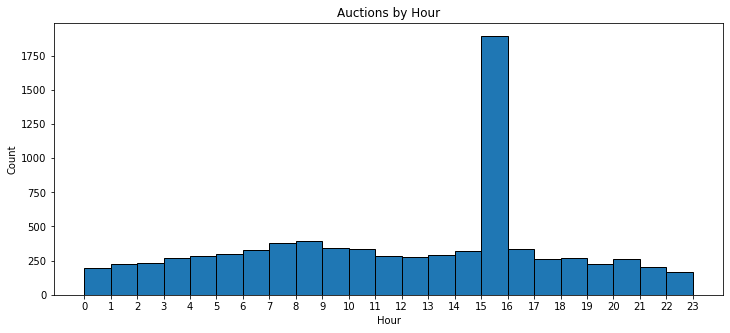

In [141]:
xtix = np.arange(0,24)
plt.figure(figsize = (12,5))
plt.hist(adSmart['hour'], edgecolor='black', bins = 23)
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Auctions by Hour')
plt.xticks(xtix)
plt.show()

In [142]:
adSmart.hour.replace([5, 6, 7, 8, 9, 10, 11, 12],'Morning', inplace = True)
adSmart.hour.replace([13, 14, 15, 16, 17, 18],'Evening', inplace = True)
adSmart.hour.replace([19, 20, 21, 22, 23, 0, 1, 2, 3, 4],'Night', inplace = True)
adSmart.rename(columns= {'hour': 'timeOfDay'}, inplace = True)

In [143]:
adSmart.timeOfDay.value_counts()

Evening    3375
Morning    2646
Night      2056
Name: timeOfDay, dtype: int64

To finish up the cleaning process the 'date, 'device_make', and 'platform_os' columns will be dropped as both these columns do not add any useful information. The length of the experiment was only 1 week long which is not long enough to provide multiple entries for the same day of the week therefore the 'date' cannot factor into the analysis. The 'device_make' is far too specific while the 'platform_os' metric is too imbalanced.

In [144]:
adSmart.device_make.value_counts()

Generic Smartphone    4743
iPhone                 433
Samsung SM-G960F       203
Samsung SM-G973F       154
Samsung SM-G950F       148
                      ... 
VKY-L09                  1
XiaoMi Redmi 8           1
Samsung SM-G900V         1
Samsung SM-N9750         1
Samsung SM-A750GN        1
Name: device_make, Length: 269, dtype: int64

In [145]:
adSmart.platform_os.value_counts()

6    7648
5     428
7       1
Name: platform_os, dtype: int64

In [146]:
adSmart.date.value_counts()

2020-07-03    2015
2020-07-09    1208
2020-07-08    1198
2020-07-04     903
2020-07-10     893
2020-07-05     890
2020-07-06     490
2020-07-07     480
Name: date, dtype: int64

In [147]:
adSmart.drop(['date', 'device_make', 'platform_os'], axis =1, inplace = True)

The dataset is now free of redundant and useless data and it also feature recategorized metrics that will create opportunities to test additional scenarios.

In [148]:
adSmart

,auction_id,experiment,timeOfDay,browser,questionaire
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,Morning,Mobile,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,Morning,Mobile,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,Night,Desktop,0
3,00187412-2932-4542-a8ef-3633901c98d9,control,Evening,Application,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,Evening,Mobile,0
...,...,...,...,...,...
8072,ffea24ec-cec1-43fb-b1d1-8f93828c2be2,exposed,Morning,Mobile,0
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,Evening,Mobile,0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,Morning,Mobile,0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,exposed,Evening,Mobile,0


#### Analysis

Similar to the process in the first case study, the two outcomes from the different scenarios will be compared and then tested using a proportion z-test to determine whether the difference between the two outcomes are statistically significant.

In [66]:
controlCount = len(adSmart.loc[((adSmart['questionaire']) == 1) & (adSmart['experiment'] == 'control')])
exposedCount = len(adSmart.loc[((adSmart['questionaire']) == 1) & (adSmart['experiment'] == 'exposed')])

controlObs = len(adSmart.loc[(adSmart['experiment']) == 'control'])
exposedObs = len(adSmart.loc[(adSmart['experiment']) == 'exposed'])

In [67]:
rateControl = round((controlCount/controlObs)*100,2)
rateExposed = round((exposedCount/exposedObs)*100,2)
print(f"The participation rate for the control vs the exposed is: {rateControl}% vs. {rateExposed}%")

The participation rate for the control vs the exposed is: 6.48% vs. 7.69%


In [68]:
partCount = [controlCount, exposedCount]
partObs =  [controlObs, exposedObs]
print(f"The p-value for the one day retention rate for the control and moved users is: {proportions_ztest(partCount, partObs)[1]}")

The p-value for the one day retention rate for the control and moved users is: 0.035005825968324515


In [81]:
morningCount = len(adSmart.loc[((adSmart['questionaire']) == 1) & (adSmart['timeOfDay'] == 'Morning')])
eveningCount = len(adSmart.loc[((adSmart['questionaire']) == 1) & (adSmart['timeOfDay'] == 'Evening')])
nightCount = len(adSmart.loc[((adSmart['questionaire']) == 1) & (adSmart['timeOfDay'] == 'Night')])

morningObs = len(adSmart.loc[(adSmart['timeOfDay']) == 'Morning'])
eveningObs = len(adSmart.loc[(adSmart['timeOfDay']) == 'Evening'])
nightObs = len(adSmart.loc[(adSmart['timeOfDay']) == 'Night'])

In [82]:
rateMorning = round((morningCount/morningObs)*100,2)
rateEvening = round((eveningCount/eveningObs)*100,2)
rateNight = round((nightCount/nightObs)*100,2)
print(f"The participation rate for different times of the day is:\n {rateMorning}% for the morning\n {rateEvening}% for the evening\n {rateNight}% for the night.")

The participation rate for different times of the day is:
 7.07% for the morning
 6.76% for the evening
 7.64% for the night.


In [83]:
partENCount = [eveningCount, nightCount]
partENObs =  [eveningObs, nightObs]
proportions_ztest(partENCount, partENObs)

(-1.2265307272737305, 0.21999901949494727)

In [ ]:
desktopCount = len(adSmart.loc[((adSmart['questionaire']) == 1) & (adSmart['browser'] == 'Desktop')])
mobileCount = len(adSmart.loc[((adSmart['questionaire']) == 1) & (adSmart['browser'] == 'Mobile')])
appCount = len(adSmart.loc[((adSmart['questionaire']) == 1) & (adSmart['browser'] == 'Application')])

desktopObs = len(adSmart.loc[(adSmart['browser']) == 'Desktop'])
mobileObs = len(adSmart.loc[(adSmart['browser']) == 'Mobile'])
appObs = len(adSmart.loc[(adSmart['browser']) == 'Application'])

In [ ]:
rateDesktop = round((desktopCount/desktopObs)*100,2)
rateMobile = round((mobileCount/mobileObs)*100,2)
rateApp = round((appCount/appObs)*100,2)
print(f"The participation rate for different times of the day is:\n {rateDesktop}% on Desktop\n {rateMobile}% on Mobile\n {rateApp}% on Applications.")

In [ ]:
partMACount = [mobileCount, appCount]
partMAObs =  [mobileObs, appObs]
print(f"The p-value between mobile and application exposed participation is: {proportions_ztest(partMACount, partMAObs)[1]}")

In [ ]:
partDACount = [desktopCount, appCount]
partDAObs =  [desktopObs, appObs]
print(f"The p-value between desktop and application exposed participation is: {proportions_ztest(partDACount, partDAObs)[1]}")

In [ ]:
partDMCount = [desktopCount, mobileCount]
partDMObs =  [desktopObs, mobileObs]
print(f"The p-value between desktop and mobile exposed participation is: {proportions_ztest(partDMCount, partDMObs)[1]}")